In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as tfk
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from validation.metrics import OME, MSE, get_CV_error
import matplotlib.pyplot as plt
from validation.tests import custom_train_test_split, get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test, small_shear_test, assign_sample_ids
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
from data_tools.data_viz import val_epochs, calc_slopes_Mw, compare_cv
from data_tools.curve_fitting import *
import keras.backend as K

/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
#Load Predictions
model_name = '2022-12-05_polysplit_polyisobutylene_test'
train_results = pd.read_pickle(f'MODELS/{model_name}/train_evals.pkl')
test_results = pd.read_pickle(f'MODELS/{model_name}/test_evals.pkl')

In [24]:
data = pd.read_pickle(f'MODELS/{model_name}/test_data.pkl')

In [29]:
test_results

,afp_C4_C4_C4,afp_C4_C4_H1,afp_H1_C4_H1,bfp_267,bfp_282,bfp_289,bfp_304,bfp_315,bfp_334,bfp_349,...,Sample_Type,SMILES,SAMPLE_ID,Test,ANN_Pred,ANN_Pred_var,GPR_Pred,GPR_Pred_var,HyperNet_Pred,HyperNet_Pred_var
1246,0.000000,0.000000,0.584958,0.677966,0.0,0.00,0.00,0.0,0.000000,0.659341,...,Blend,"[*]O[Si]([*])(C)C, [*]CC([*])(C)C",2955.0,True,6.559482,0.756568,2.915178,65.480639,4.963006,0.312813
1247,0.000000,0.000000,0.584958,0.677966,0.0,0.00,0.00,0.0,0.000000,0.659341,...,Blend,"[*]O[Si]([*])(C)C, [*]CC([*])(C)C",2955.0,True,6.692038,0.679548,2.755505,65.492047,4.924059,0.291184
1248,0.000000,0.000000,0.584958,0.677966,0.0,0.00,0.00,0.0,0.000000,0.659341,...,Blend,"[*]O[Si]([*])(C)C, [*]CC([*])(C)C",2955.0,True,6.712826,0.687433,2.597166,65.503724,4.983828,0.216767
1249,0.000000,0.000000,0.584958,0.677966,0.0,0.00,0.00,0.0,0.000000,0.659341,...,Blend,"[*]O[Si]([*])(C)C, [*]CC([*])(C)C",2955.0,True,6.602254,0.540605,2.440246,65.515604,4.968477,0.294722
1250,0.000000,0.000000,0.584958,0.677966,0.0,0.00,0.00,0.0,0.000000,0.659341,...,Blend,"[*]O[Si]([*])(C)C, [*]CC([*])(C)C",2955.0,True,6.199233,0.554581,2.277160,65.528224,4.915521,0.358361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,0.583333,0.833333,0.583333,0.666667,0.0,0.25,1.75,0.0,0.666667,0.666667,...,Homopolymer,[*]CC([*])(C)C,1226.0,True,4.715926,0.964150,5.188618,2.107197,7.787174,0.151215
1860,0.583333,0.833333,0.583333,0.666667,0.0,0.25,1.75,0.0,0.666667,0.666667,...,Homopolymer,[*]CC([*])(C)C,1226.0,True,4.838881,1.310778,6.047400,2.161993,8.391455,0.225233
1861,0.583333,0.833333,0.583333,0.666667,0.0,0.25,1.75,0.0,0.666667,0.666667,...,Homopolymer,[*]CC([*])(C)C,1227.0,True,4.313566,0.879380,4.333408,2.511714,7.134367,0.198815
1862,0.583333,0.833333,0.583333,0.666667,0.0,0.25,1.75,0.0,0.666667,0.666667,...,Homopolymer,[*]CC([*])(C)C,1227.0,True,4.918062,0.949486,5.681212,2.626101,8.126825,0.262078


2022-12-08 15:21:55.646103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 15:21:56.346489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30985 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:da:00.0, compute capability: 7.0


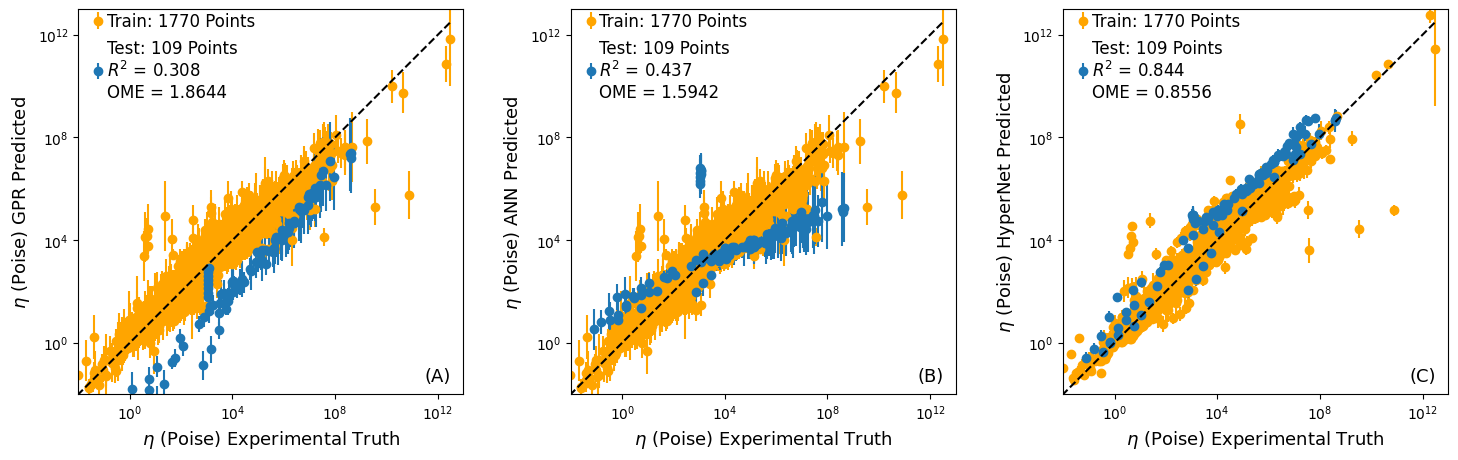

In [30]:
yy = np.array(train_results['Melt_Viscosity'])
y_test = np.array(test_results['Melt_Viscosity'])

#ANN Plot

fig = plt.figure(figsize = (18,5))
fig.tight_layout(pad = 2)
ax2, ax1, ax3 = plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)

train_pred = np.array(train_results['ANN_Pred'])
test_pred = np.array(test_results['ANN_Pred'])
train_var = np.array(train_results['ANN_Pred_var'])
test_var = np.array(test_results['ANN_Pred_var'])

ax1.errorbar(yy, list(train_pred.reshape(-1,)), yerr = list(np.array(train_var).reshape(-1,)), c = 'orange', fmt = 'o', label = f'Train: {train_pred.shape[0]} Points') 
#+ r'$R^2$ = ' + "{:1.3f}, ".format(r2_score(yy, train_pred)) + "OME = {:1.4f}".format(get_CV_error(NN_cv, scaler= y_scaler)))

ax1.errorbar(y_test , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o', label = f'Test: {test_pred.shape[0]} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test, test_pred)))

ax1.plot(np.linspace((min(yy)), (max(yy)), num = 2),np.linspace((min(yy)), (max(yy)), num = 2),'k--', zorder = 10)
ax1.set_ylabel(r'$\eta$ (Poise) ANN Predicted', fontsize = 13)
ax1.set_xlabel(r'$\eta$ (Poise) Experimental Truth', fontsize = 13)
ax1.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#plt.title('ANN Parity Plot')
ax1.set_xlim(-2, 13)
ax1.set_ylim(-2, 13)
ax1.annotate('(B)', (11.5,-1.5), fontsize = 13)
ax1.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'])
ax1.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'])
#ax1.set_yticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
#ax1.set_xticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])

#plt.gca().set_aspect('equal', adjustable='box')
ax1.set_box_aspect(1)


#GPR Plot
test_pred, var = np.array(test_results['GPR_Pred']), np.array(test_results['GPR_Pred_var'])
#train_pred, var_train = np.array(train_results['GPR_Pred']), np.array(train_results['GPR_Pred_var'])

test_pred = test_pred.reshape(-1,1)
train_pred = train_pred.reshape(-1,1)

high_var = np.argmax(y_test - test_pred, 0)
test_pred = np.delete(test_pred,high_var)
y_test_gpr = np.delete(y_test,high_var)
test_var= np.delete(test_var,high_var)


ax2.errorbar(yy, list(train_pred.reshape(-1,)), yerr = list(np.array(train_var).reshape(-1,)), c = 'orange', fmt = 'o', label = f'Train: {train_pred.shape[0]} Points') 
ax2.errorbar(y_test_gpr , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o', label = f'Test: {test_pred.shape[0] + 1} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test_gpr, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test_gpr, test_pred)))


ax2.plot(np.linspace((min(yy)), (max(yy)), num = 2),np.linspace((min(yy)), (max(yy)), num = 2),'k--', zorder = 10)
ax2.set_ylabel(r'$\eta$ (Poise) GPR Predicted', fontsize = 13)
ax2.set_xlabel(r'$\eta$ (Poise) Experimental Truth', fontsize = 13)
ax2.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#ax2.title('GPR Parity Plot')
ax2.set_xlim(-2, 13)
ax2.set_ylim(-2, 13)
ax2.set_box_aspect(1)
ax2.annotate('(A)', (11.5,-1.5), fontsize = 13)
# ax2.set_yticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
# ax2.set_xticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
ax2.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'])
ax2.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'])


#HypNet
train_pred = np.array(train_results['HyperNet_Pred'])
test_pred = np.array(test_results['HyperNet_Pred'])
train_var = np.array(train_results['HyperNet_Pred_var'])
test_var = np.array(test_results['HyperNet_Pred_var'])

ax3.errorbar(yy, list(train_pred.reshape(-1,)), yerr = list(np.array(train_var).reshape(-1,)), c = 'orange', fmt = 'o', label = f'Train: {train_pred.shape[0]} Points') 
#+ r'$R^2$ = ' + "{:1.3f}, ".format(r2_score(yy, train_pred)) + "OME = {:1.4f}".format(get_CV_error(NN_cv, scaler= y_scaler)))

ax3.errorbar(y_test , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o', label = f'Test: {test_pred.shape[0]} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test, test_pred)))

ax3.plot(np.linspace((min(yy)), (max(yy)), num = 2),np.linspace((min(yy)), (max(yy)), num = 2),'k--', zorder = 10)
ax3.set_ylabel(r'$\eta$ (Poise) HyperNet Predicted', fontsize = 13)
ax3.set_xlabel(r'$\eta$ (Poise) Experimental Truth', fontsize = 13)
ax3.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#plt.title('ANN Parity Plot')
ax3.set_xlim(-2, 13)
ax3.set_ylim(-2, 13)
ax3.annotate('(C)', (11.5,-1.5), fontsize = 13)
ax3.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'])
ax3.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'])
ax3.set_box_aspect(1)

#plt.gca().set_aspect('equal', adjustable='box')

#plt.savefig('Paper_Fig/parity_plots_new.pdf', dpi=300, bbox_inches="tight")
plt.savefig('../../../data/ayush/Melt_Viscosity_Predictor/parity_poly_split.svg', dpi=300, bbox_inches="tight")
